In [4]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import time


In [5]:
env_name = "MountainCar-v0"
env = gym.make(env_name)
obs = env.reset()
def show_state(env, step=0, info=""):
    plt.imsave('SARSA.jpg', env.render(mode='rgb_array'))

show_state(env )

In [6]:
# Some initializations
#
n_states = 40  #the width of 1-dim 
episodes = 10
initial_lr = 1.0 #learning rate
min_lr = 0.005
gamma = 0.99
max_stps = 300
epsilon = 0.05
env = env.unwrapped
env.seed()
np.random.seed(2)



In [7]:
# Quantize the states
#
def discretization(env, obs):
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_den = (env_high - env_low) / n_states
    pos_den = env_den[0]
    vel_den = env_den[1]
    pos_high = env_high[0]
    pos_low = env_low[0]
    vel_high = env_high[1]
    vel_low = env_low[1]
    pos_scaled = int((obs[0] - pos_low) / pos_den)
    vel_scaled = int((obs[1] - vel_low) / vel_den)
    return pos_scaled, vel_scaled
q_table = np.zeros((n_states, n_states, env.action_space.n))



In [8]:
#SARSA

total_steps = []
reward_list = []
q_table_list = []
    

for episode in range(episodes):
    print("Episode begin:", episode)
    obs = env.reset()
    total_reward = 0
    alpha = max(min_lr, initial_lr*(gamma**(episode//100)))
    steps = 0
    
    #choose A from S using policy derived from Q
    #env.render() #刷新当前环境
    pos, vel = discretization(env, obs)
    #update action
    if np.random.uniform(low=0, high=1) < epsilon:
        a = np.random.choice(env.action_space.n)
    else:
        a = np.argmax(q_table[pos][vel])
    
     
    while True:
        #take action A, observe R,S'
        obs, reward, terminate,_ = env.step(a)
        total_reward += abs(obs[0]+0.5)
        pos_, vel_ = discretization(env, obs) #vel 速度
        
        #choose A' from S' using policy dervided from Q
        #update action
        if np.random.uniform(low=0, high=1) < epsilon:
            a_ = np.random.choice(env.action_space.n)
        else:
            a_ = np.argmax(q_table[pos][vel])
        
        # Q function update
        #
        #q_table[pos][vel][a] = (1-alpha)*q_table[pos][vel][a] + alpha*(reward+gamma*np.max(q_table[pos_][vel_]))
        q_table[pos][vel][a] = q_table[pos][vel][a]+alpha*(reward+gamma*q_table[pos_][vel_][a_]-q_table[pos][vel][a])
        a = a_
        pos, vel = discretization(env, obs)
        
        steps += 1
        
        
        if terminate:
            print('Done!', "Episode:", episode, 'total_steps=',steps, 'total_reward: ',total_reward)
            reward_list.append(total_reward)
            q_table_list.append(q_table)
        
            break

            
env.close()

Episode begin: 0
Done! Episode: 0 total_steps= 62219 total_reward:  19760.654731501432
Episode begin: 1
Done! Episode: 1 total_steps= 1346 total_reward:  435.8069334876015
Episode begin: 2
Done! Episode: 2 total_steps= 9807 total_reward:  3587.3882699204682
Episode begin: 3
Done! Episode: 3 total_steps= 14242 total_reward:  3394.980853170466
Episode begin: 4
Done! Episode: 4 total_steps= 3932 total_reward:  1420.725822742768
Episode begin: 5
Done! Episode: 5 total_steps= 6335 total_reward:  2057.606107875409
Episode begin: 6
Done! Episode: 6 total_steps= 10653 total_reward:  4482.90206320064
Episode begin: 7
Done! Episode: 7 total_steps= 2860 total_reward:  576.169693454314
Episode begin: 8
Done! Episode: 8 total_steps= 24153 total_reward:  6776.586702812543
Episode begin: 9
Done! Episode: 9 total_steps= 5124 total_reward:  1311.1707871925282


In [47]:
###select max reward from q_table
opi_episode = reward_list.index(max(reward_list))
q_table_opi = q_table_list[opi_episode]
print('opi_episode',opi_episode, q_table_opi.shape)

opi_episode 0 (40, 40, 3)


In [48]:
from itertools import product
import numpy as np
from sklearn.cluster import KMeans

X_opit = np.array(list(product(q_table_opi[:,0,0], q_table_opi[0,:,0])))
y = q_table_opi.reshape((n_states * n_states, 3))
print(X_opit.shape)

(1600, 2)


In [49]:
def rbf(X, y, j):
    J = j
    N = X.shape[0]

    kmeans = KMeans(n_clusters=J, random_state=0).fit(X)
    sig = np.std(X)
    # Construct design matrix
    U = np.zeros((N,J))
    for i in range(N):
        for j in range(J):
           U[i][j] = np.linalg.norm(X[i] - kmeans.cluster_centers_[j])
    # Solve RBF model, predict and plot
    
    w = np.dot((np.linalg.inv(np.dot(U.T,U))), U.T).dot(y)
    yh_rbf = np.dot(U,w)
    error = np.linalg.norm(y-yh_rbf)
    return error, yh_rbf
    

Text(0.5, 1.0, 'SARSA update rules for RBF model')

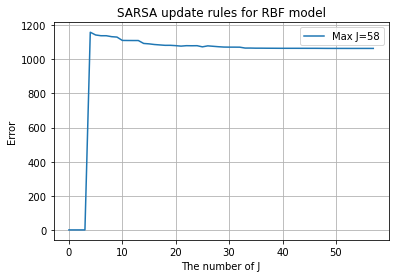

In [57]:
MaxIter = 58
Eplot = np.zeros((MaxIter,1))
for i in range(4, MaxIter, 1):
    error, yPred = rbf(X_opit, y, i)
    Eplot[i]  = error

fig,ax = plt.subplots()
ax.plot(Eplot, label=u'Max J=58')
ax.set_xlabel("The number of J")
ax.set_ylabel("Error")
ax.grid(True)
plt.legend()
ax.set_title("SARSA update rules for RBF model")

In [73]:
print('Minimum error by SARSA: ', min(Eplot[4:]))

Minimum error by SARSA:  [1063.95141423]


<ipython-input-65-163d0af087f8>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(positions, velocities, q_values[:, :, action])
<ipython-input-65-163d0af087f8>:41: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(positions, velocities, v_values)


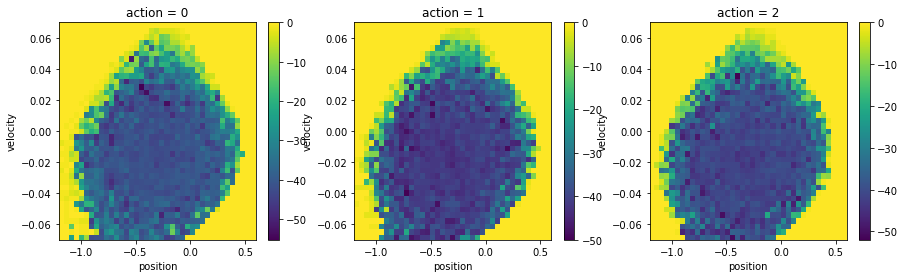

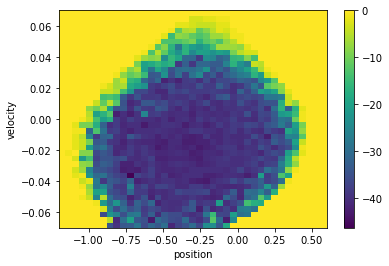

In [65]:
###plot score and policy
'''
poses = q_table_opi[:,0,0]
vels = q_table_opi[0,:,0]

positions = X_opit[:,0]
positions, velocities = np.meshgrid(poses, vels)
'''
poses = np.linspace(env.unwrapped.min_position,
          env.unwrapped.max_position, 40)
vels = np.linspace(-env.unwrapped.max_speed, env.unwrapped.max_speed, 40)
positions, velocities = np.meshgrid(poses, vels)

# Draw action value estimate

'''
@np.vectorize
def get_q(position, velocity, action):
    pos 
    return q_table.get_q(position, velocity, action)
'''

q_values = np.empty((len(poses), len(vels), 3))
for action in range(3):
    q_values[:, :, action] =  q_table_opi[:,:,action]


fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for action, ax in enumerate(axes):
    c = ax.pcolormesh(positions, velocities, q_values[:, :, action])
    ax.set_xlabel('position')
    ax.set_ylabel('velocity')
    fig.colorbar(c, ax=ax)
    ax.set_title('action = {}'.format(action))

# Draw state value estimate

v_values = q_values.max(axis=-1)

fig, ax = plt.subplots(1, 1)
c = ax.pcolormesh(positions, velocities, v_values)
ax.set_xlabel('position')
ax.set_ylabel('velocity')
fig.colorbar(c, ax=ax)

In [74]:
print('Best solution is: ', np.argmax(q_table_opi, axis=2))
print('Average score fo solution = ', np.mean(y))

Best solution is:  [[0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Average score fo solution =  -20.409597105230684


Text(0.5, 1.0, 'Score by SARSA')

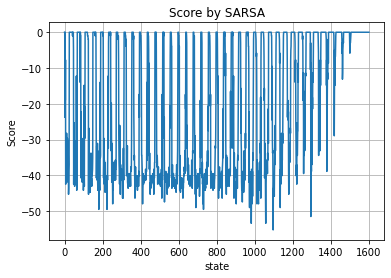

In [77]:
fig,ax = plt.subplots()
ax.plot(range(len(y)), y[:,0])
ax.set_xlabel("state")
ax.set_ylabel("Score")
ax.grid(True)
#plt.legend()
ax.set_title("Score by SARSA")